In [1]:
import numpy as np
import IPython
import scipy.signal as signal
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from librosa.display import specshow

In [2]:
#@title Recording code

!apt install ffmpeg
!pip install ffmpeg-python
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import urllib
import ffmpeg
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [3]:
def plot_spec(data, rate, n_fft=512, hop_length=256, win_length=256, yscale='linear'):
    plt.clf()
    spec = librosa.amplitude_to_db(np.abs(librosa.stft(data, n_fft=n_fft, hop_length=hop_length, win_length=win_length)))
    specshow(spec, sr=rate, y_axis=yscale, x_axis='time', cmap='viridis')
    plt.colorbar()
    plt.show()

With Sine

In [4]:
f1 = 25
f2 = 50
N = 10
t = np.linspace(0, 1, 1000)

sig = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)

V =  W x H ( V >= 0, H >= 0, W >= 0)

In [5]:
def loss(A, B):
    return np.sqrt(np.sum((A-B)**2))  #RMSE

def iterate(V, num_basis, steps, show_every=20):
    n, m = V.shape
    W = np.random.random((n,num_basis))
    H = np.random.random((num_basis,m))
    losses = [loss(V, np.dot(W,H))]
    print(losses[-1])
    for i in range(steps):
        W = W*(np.dot(V/np.dot(W,H),H.T))/(np.sum(H,axis=1,keepdims=True)).T
        H = H*(np.dot(W.T,V/np.dot(W,H)))/(np.sum(W,axis=0,keepdims=True)).T
        losses.append(loss(V,np.dot(W,H)))
        if i%show_every == 0:
            print(losses[-1])
    plt.plot(losses)
    return (W, H)

289.218921159178
103.92490382351605
3.4126134150476255
1.0626259949647092
0.7408967404698307
0.6368296546096712
0.5992710138206028
0.5986767946661122
0.5998524998398123
0.6004853162803083
0.5911234349911924


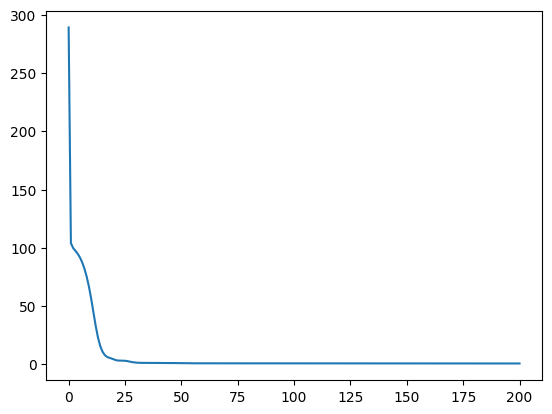

In [6]:
spec = librosa.stft(sig, n_fft=512, hop_length=256, win_length=256)
V = spec
steps = 200
num_basis = 2
W, H = iterate(np.abs(V), num_basis, steps)

In [7]:
from sklearn.decomposition import NMF
model = NMF(n_components=3, init='nndsvd', random_state=0,solver="mu",beta_loss="frobenius",max_iter = 1000)
W = model.fit_transform(np.abs(spec))
H = model.components_
print(model.reconstruction_err_)

5.795759886043818


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1524: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


In [8]:
!git clone https://github.com/tky823/audio_source_separation.git

Cloning into 'audio_source_separation'...
remote: Enumerating objects: 3464, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 3464 (delta 148), reused 232 (delta 148), pack-reused 3228
Receiving objects: 100% (3464/3464), 22.69 MiB | 29.90 MiB/s, done.
Resolving deltas: 100% (2036/2036), done.


In [9]:
%cd "/content/audio_source_separation/egs/nmf-example/kl-nmf"

/content/audio_source_separation/egs/nmf-example/kl-nmf


In [10]:
import sys
sys.path.append("../../../src")

In [11]:
import numpy as np
import scipy.signal as ss
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt

In [12]:
from algorithm.nmf import KLNMF

In [13]:
plt.rcParams['figure.dpi'] = 200

In [14]:
fft_size, hop_size = 1024, 256

In [15]:
# url = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/fish.wav"
# response = urllib.request.urlopen(url)
# x, sr = sf.read(io.BytesIO(response.read()))

In [16]:
x, sr = sf.read("../../../dataset/sample-song/sample-1_electric-guitar_8000.wav")
_, _, spectrogram_real = ss.stft(x, nperseg=fft_size, noverlap=fft_size-hop_size)
X_real = np.abs(spectrogram_real)**2
n_basis = 6
np.random.seed(111)
nmf = KLNMF(n_basis=n_basis)
basis_real, activation_real = nmf(X_real, iteration=100)

In [17]:
ipd.Audio(x, rate=sr)

In [18]:
x = x + np.random.rand(len(x))
ipd.Audio(x, rate=sr)

In [19]:
np.random.seed(111)
nmf = KLNMF(n_basis=n_basis)
_, _, spectrogram = ss.stft(x, nperseg=fft_size, noverlap=fft_size-hop_size)
X = np.abs(spectrogram)**2
basis, activation = nmf(X, iteration=100)

In [20]:
basis.shape, activation.shape, basis_real.shape, activation_real.shape

((513, 6), (6, 705), (513, 6), (6, 705))

In [21]:
X[X < 1e-12] = 1e-12
Z = basis @ activation

ratio = np.sqrt(Z / X)

estimated_spectrogram = ratio * spectrogram
_, estimated_signal = ss.istft(estimated_spectrogram, nperseg=fft_size, noverlap=fft_size-hop_size)
estimated_signal = estimated_signal / np.abs(estimated_signal).max()
ipd.Audio(estimated_signal, rate=sr)

In [22]:
X[X < 1e-12] = 1e-12
# Z = basis_real @ activation
Z = basis @ activation_real

ratio = np.sqrt(Z / X)

estimated_spectrogram = ratio * spectrogram
_, estimated_signal = ss.istft(estimated_spectrogram, nperseg=fft_size, noverlap=fft_size-hop_size)
estimated_signal = estimated_signal / np.abs(estimated_signal).max()
ipd.Audio(estimated_signal, rate=sr)

In [23]:
for idx in range(n_basis):
    Z = basis[:, idx: idx+1] * activation[idx: idx+1, :]

    ratio = np.sqrt(Z / X)

    estimated_spectrogram = ratio * spectrogram
    _, estimated_signal = ss.istft(estimated_spectrogram, nperseg=fft_size, noverlap=fft_size-hop_size)
    estimated_signal = estimated_signal / np.abs(estimated_signal).max()
    display(ipd.Audio(estimated_signal, rate=sr))

Output hidden; open in https://colab.research.google.com to view.

In [24]:
for idx in range(n_basis):
    Z = basis_real[:, idx: idx+1] * activation[idx: idx+1, :]

    ratio = np.sqrt(Z / X)

    estimated_spectrogram = ratio * spectrogram
    _, estimated_signal = ss.istft(estimated_spectrogram, nperseg=fft_size, noverlap=fft_size-hop_size)
    estimated_signal = estimated_signal / np.abs(estimated_signal).max()
    display(ipd.Audio(estimated_signal, rate=sr))

Output hidden; open in https://colab.research.google.com to view.